## Imports, Classes, and Constants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

RANDOM_SEED = 42

class StemCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemCountVectorizer, self).build_analyzer()
        
        return lambda document: ([SnowballStemmer('english', ignore_stopwords=True).stem(word) for word in analyzer(document)])

## Data Preprocessing

In [2]:
mcu_subset = pd.read_csv("./data/mcu_subset.csv")

np.random.seed(RANDOM_SEED)
mcu_subset = mcu_subset.reindex(np.random.permutation(mcu_subset.index))

mcu_subset.head()

,Unnamed: 0,character,line,movie,year,words,Adam McKay,Anna Boden,Art Marcum,Ashley Edward Miller,...,Joss Whedon,Justin Theroux,Mark Fergus,Matt Holloway,Paul Rudd,Ryan Coogler,Ryan Fleck,Shane Black,Stephen McFeely,Zack Stentz
1263,2218,THOR,"Stay here. Once I have Mjolnir, I will return what they stole from you. Deal?",Thor,2011,15,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
3951,7527,THOR,They'll try to leave the city.,Avengers: Age of Ultron,2015,6,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4198,8890,TONY STARK,"Oh, yeah. It'd be great if we had a Hulk right about now. Any shot?",Captain America: Civil War,2016,15,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
6078,14843,BRUCE BANNER,It was worse for me. Because I lost twice. First Hulk lost. Then Banner lost. Then we all lost.,Avengers: Endgame,2019,23,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
96,141,TONY STARK,"Okay, here’s what I need... S-Category missiles. Lot 7043. The S-30 explosive tritonal. And a dozen of the S-76. Mortars: M-Category #1, 4, 8, 20, and 60. M- 229’s, I need eleven of these. Mines: the pre-90s AP 5s and AP 16s.",Iron Man,2008,49,False,False,True,False,...,False,False,True,True,False,False,False,False,False,False


In [3]:
pd.DataFrame(mcu_subset['character'].value_counts())

,character
TONY STARK,1788
STEVE ROGERS,977
THOR,863
PETER PARKER,551
NATASHA ROMANOFF,498
PEPPER POTTS,442
BRUCE BANNER,379
NICK FURY,366
LOKI,327
JAMES RHODES,318


In [4]:
y = mcu_subset["character"].to_numpy().astype(str)
X = mcu_subset["line"].to_numpy().astype(str)

X[0:10], y[0:10]

(array(['Stay here. Once I have Mjolnir, I will return what they stole from you. Deal?',
        "They'll try to leave the city.",
        "Oh, yeah. It'd be great if we had a Hulk right about now. Any shot?",
        'It was worse for me.  Because I lost twice.  First Hulk lost.  Then Banner lost.  Then we all lost.',
        'Okay, here’s what I need... S-Category missiles.  Lot 7043.  The S-30 explosive tritonal.  And a dozen of the S-76.  Mortars: M-Category #1, 4, 8, 20, and 60.  M- 229’s, I need eleven of these.  Mines: the pre-90s AP 5s and AP 16s. ',
        'A little.',
        "You really think I'd need one? My wife kicked me out.",
        'Is this is a test?', 'What about Ultron himself?',
        'Who put me there? Who put me there?!'], dtype='<U1388'),
 array(['THOR', 'THOR', 'TONY STARK', 'BRUCE BANNER', 'TONY STARK',
        'STEVE ROGERS', 'NICK FURY', 'STEVE ROGERS', 'STEVE ROGERS',
        'LOKI'], dtype='<U16'))

## Models

In [5]:
cross_validator = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
score_method = "balanced_accuracy"

In [6]:
stem_count_vectorizer = StemCountVectorizer(binary=False)
tfidf_transformer = TfidfTransformer()
nb_classifier = MultinomialNB(alpha=0.01)

In [7]:
count_params = {'vect__stop_words': [None, stopwords.words('english')],
              'vect__ngram_range': [(1,1), (1,2)]}

tfidf_params = {'tfidf__use_idf': [True, False]}

nb_params = {'clf__fit_prior': [True, False]}

In [8]:
pipe13 = Pipeline([('vect', stem_count_vectorizer),
                  ('tfidf', tfidf_transformer),
                  ('clf', nb_classifier)])

parameters13 = {**count_params, **tfidf_params, **nb_params}

model13 = GridSearchCV(pipe13, parameters13, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=6)

## Nested CV Balanced Accuracy

In [9]:
models = {"model 13": model13}

cv_score_table = pd.DataFrame()

for name, model in models.items():
    results = cross_val_score(model, X, y, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=6)
    cv_score_table.insert(len(cv_score_table.columns), name, results, True)

cv_score_table.index.name = "fold"
cv_score_table.loc["mean"] = cv_score_table.mean()
cv_score_table.loc["std"] = cv_score_table.std()
cv_score_table.loc["max"] = cv_score_table.max()

cv_score_table

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 133.3min remaining: 310.9min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 133.4min remaining: 133.4min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 133.7min remaining: 57.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 133.7min finished


,model 13
fold,
0,0.272321
1,0.331317
2,0.261578
3,0.274342
4,0.317787
5,0.273837
6,0.301571
7,0.291454
8,0.305024


## Confusion Matrix

Balanced Accuracy: 0.29041080720970575
Balanced Accuracy: 0.2904108072097057


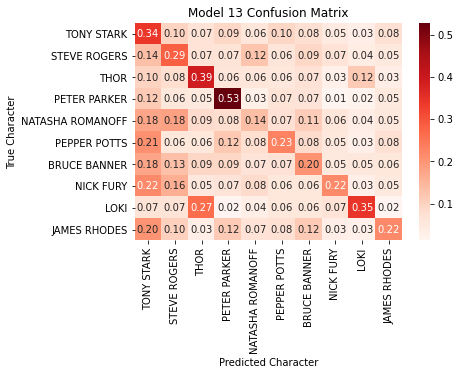

In [20]:
yhat = cross_val_predict(model13, X, y, cv=cross_validator, n_jobs=-1, verbose=6)

main_characters = mcu_subset['character'].value_counts().index.to_numpy()

conf_matrix = pd.DataFrame(metrics.confusion_matrix(y, yhat, labels=main_characters))
normalized_conf_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
normalized_conf_matrix.columns = pd.Series(main_characters, name="Predicted Character")
normalized_conf_matrix.index = pd.Series(main_characters, name="True Character")

plt.title("Model 13 Confusion Matrix")
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(normalized_conf_matrix)))

## Recalls

In [11]:
recalls = pd.DataFrame(np.diagonal(normalized_conf_matrix.to_numpy()), index=main_characters, columns=["recall"])
recalls.sort_values(by="recall", ascending=False, inplace=True)
recalls.loc['mean'] = recalls.mean()

recalls.to_csv("./front_end/production_recalls.csv")

recalls

,recall
PETER PARKER,0.528131
THOR,0.392816
LOKI,0.345566
TONY STARK,0.342841
STEVE ROGERS,0.285568
PEPPER POTTS,0.230769
JAMES RHODES,0.220126
NICK FURY,0.218579
BRUCE BANNER,0.203166
NATASHA ROMANOFF,0.136546


## Prediction Table

In [12]:
prediction_table = pd.DataFrame({"line": X, "true character": y, "predicted character": yhat, "movie": mcu_subset['movie']})

prediction_table.sort_index(inplace=True)

dump(prediction_table, "./front_end/production_predictions.joblib")

prediction_table.head()

,line,true character,predicted character,movie
0,"Oh, I get it. You guys aren’t allowed to talk. Is that it? Are you not allowed to talk?",TONY STARK,PEPPER POTTS,Iron Man
1,Oh. I see. So it’s personal.,TONY STARK,TONY STARK,Iron Man
2,"Good God, you’re a woman. I, honestly, I couldn’t have called that. I would apologize, but isn’t that what we’re going for here? I saw you as a soldier first.",TONY STARK,THOR,Iron Man
3,Please.,TONY STARK,PETER PARKER,Iron Man
4,"Excellent question. Yes and no. March and I had a schedule conflict but, thankfully, the Christmas cover was twins. Anyone else? You, with the hand up.",TONY STARK,TONY STARK,Iron Man


## Learning Curve

In [13]:
def plot_learning_curve(estimator, title, X, y, axes=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, verbose=6)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")

    return

[learning_curve] Training set sizes: [ 585 1903 3221 4539 5858]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed: 57.3min remaining: 420.5min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed: 141.7min remaining: 330.5min
[Parallel(n_jobs=-1)]: Done  24 out of  50 | elapsed: 196.6min remaining: 213.0min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed: 268.6min remaining: 138.3min
[Parallel(n_jobs=-1)]: Done  42 out of  50 | elapsed: 332.6min remaining: 63.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 373.4min finished


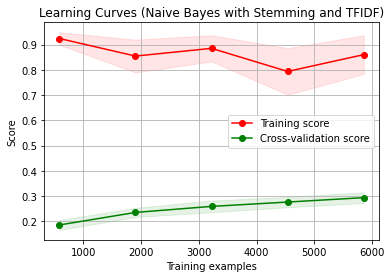

In [14]:
title = "Learning Curves (Naive Bayes with Stemming and TFIDF)"

plot_learning_curve(model13, title, X, y, cv=cross_validator)

## Peformance as a function of words

Do examples with more words (longer examples) get classified correctly more often?

In [15]:
prediction_table = load("./front_end/production_predictions.joblib")

prediction_table['words'] = prediction_table['line'].str.split(" ").str.len()
prediction_table['correct_prediction'] = (prediction_table['true character'] == prediction_table['predicted character']).astype('int64')

In [16]:
reg_model = smf.ols('prediction_table["correct_prediction"] ~ prediction_table["words"]', data=prediction_table).fit()

reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     prediction_table["correct_prediction"]   R-squared:                       0.016
Model:                                                OLS   Adj. R-squared:                  0.016
Method:                                     Least Squares   F-statistic:                     107.8
Date:                                    Sat, 16 Jan 2021   Prob (F-statistic):           4.72e-25
Time:                                            03:46:29   Log-Likelihood:                -4175.7
No. Observations:                                    6509   AIC:                             8355.
Df Residuals:                                        6507   BIC:                             8369.
Df Model:                                               1                                         
Covariance Type:                                nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.2644      0.007     36.088      0.000       0.250       0.279
prediction_table["words"]     0.0044      0.000     10.382      0.000       0.004       0.005
==============================================================================
Omnibus:                    16470.009   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1146.720
Skew:                           0.803   Prob(JB):                    9.84e-250
Kurtosis:                       1.716   Cond. No.                         22.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'accuracy')

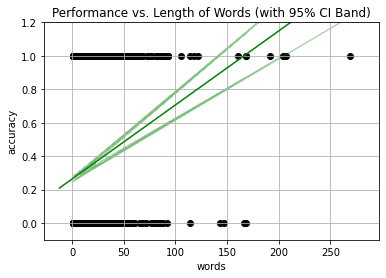

In [17]:
def abline(intercept, slope, col):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', color=col)
    

plt.scatter(x = prediction_table['words'].to_numpy(),
            y = prediction_table['correct_prediction'].to_numpy(),
            color='black')

abline(reg_model.params[0], reg_model.params[1], 'green')

conf_pred_intervals = reg_model.get_prediction(prediction_table['words']).summary_frame()

plt.fill_between(prediction_table['words'], conf_pred_intervals['mean_ci_lower'], conf_pred_intervals['mean_ci_upper'], alpha=0.3, color='green')

plt.grid()
plt.ylim(-0.1,1.2)
plt.title('Performance vs. Length of Words (with 95% CI Band)')
plt.xlabel('words')
plt.ylabel('accuracy')

Using a t test and a confidence level of 95% ($\alpha=0.05$), we **reject** the null hypothesis that there is no relationship between the number of words in an example and our model's performance on it ($t=10.382$, $p<0.001$).

The Word Count Models notebook show that this correlation is not a causation, as those models alter the data so that the word count of each example increases.  Those models to not perform better than this model, meaning that having longer lines does not mean the chance of prediction is higher.

## Export Model

In [18]:
model13.fit(X,y)
prod_model = model13.best_estimator_
dump(prod_model, './front_end/production_model.joblib')

prod_model

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 12.8min finished


Pipeline(steps=[('vect', StemCountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=0.01, fit_prior=False))])

In [19]:
model13.best_params_

{'clf__fit_prior': False,
 'tfidf__use_idf': True,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}